# Exploratory Data Analysis
Summary:  
1. Spatial distribution of trips
2. Evaluation of local trip purpose distribution (LTPD)
3. Evaluation of POI distribution by trip purpose

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import shapely
import numpy as np
import seaborn as sns
import datetime
import random

from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext


%matplotlib inline

#### Load in data

In [2]:
X_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../Data/model_inputs/gdf_2017_y.csv')

In [3]:
# combine both X, y and date times
all_17 = pd.concat([X_17, y_17],axis=1)

# merge the times for start and end of trip
start_end_times = gpd.read_file('../../Data/mtl_trajet/mtl_trajet_2017_final.shp')[['id_trip','starttime','endtime']]
all_17 = all_17.merge(start_end_times, on='id_trip')

# turn these new columns into datetime objects
all_17['starttime'] = pd.to_datetime(all_17['starttime'])
all_17['endtime'] = pd.to_datetime(all_17['endtime'])

In [4]:
mtl_region = gpd.read_file("../../Data/shapes/mtl_regions.json")
mtl_dissem = gpd.read_file("../../Data/shapes/mtl_dissem.geojson")
city_of_montreal = mtl_region.loc[(mtl_region.AIRE > 0) & (mtl_region.TYPE == 'Arrondissement')]
mtl_greater = gpd.read_file("../../Data/shapes/greater_montreal.geojson")
mtl_water_outline = gpd.read_file("../../Data/shapes/mtl_water_outline_rough.geojson")

#### turn into GeoDataFrame

In [5]:
all_17['end_point'] = all_17.apply(lambda row: \
                                                     shapely.geometry.Point(row['long'],row['lat']), axis=1)

In [6]:
gdf_17 = gpd.GeoDataFrame(all_17, geometry='end_point', crs="EPSG:4326")

In [7]:
# https://gis.stackexchange.com/questions/338498/why-do-i-get-error-runtime-bno-arguments-in-initialization-list-when-runnin
gdf_17 = gdf_17.to_crs({'init': 'epsg:3347'})

/home/thomaskeel/anaconda3/envs/datasci/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [8]:
mtl_greater['geometry'] = mtl_greater.buffer(0.01)

In [9]:
gdf_17

,id_trip,mode,distance_m,duration,weekday,morning,midday,afternoon,evening,midnight,lat,long,purpose,starttime,endtime,end_point
0,150744,2,9935.922336,862,1,1,0,0,0,0,45.550661,-73.545318,3,2017-09-18 10:02:50,2017-09-18 10:17:12,POINT (7631863.768 1250414.941)
1,35763,2,6832.113937,1873,1,0,1,0,0,0,45.408982,-73.472673,2,2017-09-18 11:32:54,2017-09-18 12:04:07,POINT (7641940.752 1236732.421)
2,323826,2,12233.968564,1165,1,0,1,0,0,0,45.610037,-73.720401,5,2017-09-18 12:25:08,2017-09-18 12:44:33,POINT (7616671.176 1252917.247)
3,375668,2,3612.405991,820,1,0,1,0,0,0,45.578748,-73.545622,0,2017-09-18 13:15:20,2017-09-18 13:29:00,POINT (7630940.820 1253445.275)
4,212877,2,26428.385191,1316,1,0,0,1,0,0,45.632435,-73.318776,0,2017-09-18 13:39:44,2017-09-18 14:01:40,POINT (7646416.073 1264377.508)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25986,187909,1,318.697272,245,1,0,0,0,0,1,45.531788,-73.597794,0,2017-10-17 23:39:37,2017-10-17 23:43:42,POINT (7628479.234 1247193.742)
25987,317829,2,325.659195,142,1,0,0,0,0,1,45.603296,-73.570546,2,2017-10-17 23:41:49,2017-10-17 23:44:11,POINT (7628262.855 1255539.419)
25988,182050,1,2481.960790,1296,1,0,0,0,0,1,45.515994,-73.577226,0,2017-10-17 23:43:44,2017-10-18 00:05:20,POINT (7630548.193 1245947.474)
25989,312741,2,2983.535698,520,1,0,0,0,0,1,45.490044,-73.569639,0,2017-10-17 23:46:46,2017-10-17 23:55:26,POINT (7631955.725 1243310.964)


# 1. Spatial distribution of trips
    1.1 Overall
    1.2 By Purpose

## 1.1 Overall

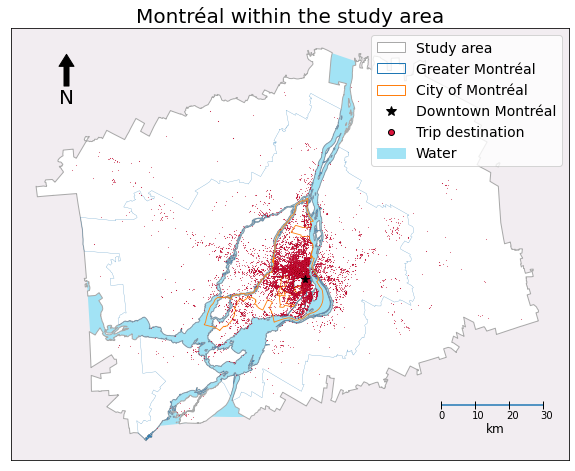

In [10]:
# sns.set_style('dark')
fig, ax = plt.subplots(1, figsize=(10,10), facecolor='white')
mtl_dissem.dissolve(by='PRNAME').plot(ax=ax, color='white', edgecolor='darkgrey', alpha=1)
mtl_greater.dissolve(by="CMANAME").plot(ax=ax, color='None', edgecolor='C0', linewidth=.25, alpha=.85)
city_of_montreal.dissolve('TYPE').plot(ax=ax, color='None', edgecolor='C1', linewidth=.85, alpha=1)
mtl_water_outline.plot(ax=ax, color='#a2e3f5', zorder=0)
plt.plot(7631671.440715431, 1245240.295997527, '*', color='k', markersize=8)
red_patch = mpatches.Patch(facecolor='white', edgecolor='darkgrey', label='Study area')
yellow_patch = mpatches.Patch(facecolor='None', edgecolor='C0', label='Greater Montréal')
blue_patch = mpatches.Patch(facecolor='None', edgecolor='C1', label='City of Montréal')
light_blue_patch = mpatches.Patch(facecolor='#a2e3f5', edgecolor='#a2e3f5', label='Water')
black_star = mlines.Line2D([0], [0], marker='*', color='k', label='Downtown Montréal',
                        markerfacecolor='k',linestyle = 'None', markersize=10)
trip_points = mlines.Line2D([0], [0], marker='o', color='k', label='Trip destination',
                        markerfacecolor='crimson',linestyle = 'None', markersize=6)


ax.legend(handles=[red_patch, yellow_patch, blue_patch, black_star, trip_points,light_blue_patch], fontsize=14)
plt.xticks([]);
plt.yticks([]);
gdf_17.plot(ax=ax, markersize=1, edgecolor='k', linewidth=0.03, alpha=.7, facecolor='crimson')
ax.patch.set_facecolor('#f2edf1')

# draw vertical line from (70,100) to (70, 250)

## Scale-bar
plt.hlines(1208240.295997527, 7671671.440715431, 7701671.440715431)
plt.plot(7671671.440715431, 1208240.295997527, '|', color='k', markersize=8)
plt.plot(7681671.440715431, 1208240.295997527, '|', color='k', markersize=8)
plt.plot(7691671.440715431, 1208240.295997527, '|', color='k', markersize=8)
plt.plot(7701671.440715431, 1208240.295997527, '|', color='k', markersize=8)
plt.text(7670671.440715431, 1204240.295997527, '0')
plt.text(7680671.440715431, 1204240.295997527, '10')
plt.text(7690671.440715431, 1204240.295997527, '20')
plt.text(7700671.440715431, 1204240.295997527, '30')
plt.text(7684671.440715431, 1200040.295997527, 'km', fontsize=12)

x, y, arrow_length = 0.1, 0.94, 0.1
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)

ax.set_title("Montréal within the study area", size=20)

plt.savefig('../../other/images/map_of_study_area.tif', bbox_inches='tight', facecolor=fig.get_facecolor(), dpi = 300, transparent=False)

# 2. Evaluation of local trip purpose distribution

In [13]:
all_17

,id_trip,mode,distance_m,duration,weekday,morning,midday,afternoon,evening,midnight,lat,long,purpose,starttime,endtime,end_point
0,150744,2,9935.922336,862,1,1,0,0,0,0,45.550661,-73.545318,3,2017-09-18 10:02:50,2017-09-18 10:17:12,POINT (-73.54532 45.55066)
1,35763,2,6832.113937,1873,1,0,1,0,0,0,45.408982,-73.472673,2,2017-09-18 11:32:54,2017-09-18 12:04:07,POINT (-73.47267 45.40898)
2,323826,2,12233.968564,1165,1,0,1,0,0,0,45.610037,-73.720401,5,2017-09-18 12:25:08,2017-09-18 12:44:33,POINT (-73.72040 45.61004)
3,375668,2,3612.405991,820,1,0,1,0,0,0,45.578748,-73.545622,0,2017-09-18 13:15:20,2017-09-18 13:29:00,POINT (-73.54562 45.57875)
4,212877,2,26428.385191,1316,1,0,0,1,0,0,45.632435,-73.318776,0,2017-09-18 13:39:44,2017-09-18 14:01:40,POINT (-73.31878 45.63243)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25986,187909,1,318.697272,245,1,0,0,0,0,1,45.531788,-73.597794,0,2017-10-17 23:39:37,2017-10-17 23:43:42,POINT (-73.59779 45.53179)
25987,317829,2,325.659195,142,1,0,0,0,0,1,45.603296,-73.570546,2,2017-10-17 23:41:49,2017-10-17 23:44:11,POINT (-73.57055 45.60330)
25988,182050,1,2481.960790,1296,1,0,0,0,0,1,45.515994,-73.577226,0,2017-10-17 23:43:44,2017-10-18 00:05:20,POINT (-73.57723 45.51599)
25989,312741,2,2983.535698,520,1,0,0,0,0,1,45.490044,-73.569639,0,2017-10-17 23:46:46,2017-10-17 23:55:26,POINT (-73.56964 45.49004)


In [20]:
def change_crs_of_X(X, crs_from="EPSG:4236",crs_to="EPSG:3347"):
    """
        Function for translating the data into Canada Lambert projection 
        EPSG: 3347, so that the base unit is 1 m
    """
    new_X = X.copy()
    new_X['geometry'] = new_X.apply(lambda row: shapely.geometry.Point(row['long'],row['lat']),axis=1)
    new_X = gpd.GeoDataFrame(new_X,crs=crs_from)
    new_X = new_X.to_crs(crs_to)
    return new_X


def calculate_average_nearby_purposes(data, purpose_type, buffer_size_m):
    """
        function for calculating average percentage of nearby trip purposes based on a buffer size and a given purpos type
    """
    if 'geometry' not in data.columns:
        geo_data = change_crs_of_X(data)
    # calculate X m buffers around each trip end point
    geo_data['buffers'] = geo_data['geometry'].apply(lambda row: row.buffer(buffer_size_m))
    # get a geo-dataframe with only the Trip ID,trip end buffer and trip purpose
    only_buffers = geo_data.loc[geo_data.purpose == purpose_type][['id_trip','buffers']]
    only_buffers = gpd.GeoDataFrame(only_buffers.rename(columns={'buffers':'geometry'}), crs="EPSG:3347")
    
    joined_data = gpd.sjoin(only_buffers, geo_data, op='intersects', how='left')

    ## drop duplicates (as each trip will fall within a buffer of itself)
    to_drop = joined_data[['id_trip_left','id_trip_right']].apply(lambda row: True \
                                                                if row['id_trip_left'] == row['id_trip_right']\
                                                                else False, axis=1)
    joined_data = joined_data[~to_drop]
    
    ## Compute the proportion of nearby purposes types for each trip/row
    grouped_data = joined_data.groupby(['id_trip_left', 'purpose']).agg({'mode':'count'})
    grouped_data = grouped_data.unstack().apply(lambda row: row/row.sum(),axis=1)['mode'].reset_index()*100
    grouped_data = grouped_data.fillna(0.0)
    return grouped_data[[0,1,2,3,4,5]].mean().values

In [22]:
%%time
ALL_AVERAGE_NEARBY_PURPOSES = {}
all_buffers = [50,100,150,200,250,300,350,400]
all_purposes = [0,1,2,3,4,5]
for buffer_size in all_buffers:
    for pur in all_purposes:
        print(buffer_size, pur)
        vals = calculate_average_nearby_purposes(data=all_17, purpose_type=pur, buffer_size_m=buffer_size)
        ALL_AVERAGE_NEARBY_PURPOSES[str(pur)+str(buffer_size)] = vals.tolist()

50 0
50 1
50 2
50 3
50 4
50 5
100 0
100 1
100 2
100 3
100 4
100 5
150 0
150 1
150 2
150 3
150 4
150 5
200 0
200 1
200 2
200 3
200 4
200 5
250 0
250 1
250 2
250 3
250 4
250 5
300 0
300 1
300 2
300 3
300 4
300 5
350 0
350 1
350 2
350 3
350 4
350 5
400 0
400 1
400 2
400 3
400 4
400 5
CPU times: user 6min 21s, sys: 3.59 s, total: 6min 25s
Wall time: 6min 24s


In [23]:
# make dataframe of all average purposes ready for plotting
all_av_np_df = pd.DataFrame.from_dict(ALL_AVERAGE_NEARBY_PURPOSES)

In [25]:
# view data
all_av_np_df

,050,150,250,350,450,550,0100,1100,2100,3100,...,2350,3350,4350,5350,0400,1400,2400,3400,4400,5400
0,48.427927,31.976453,25.999223,29.519332,17.862159,30.593658,46.547046,32.201711,27.333097,30.993885,...,29.560636,33.800409,25.035613,32.585115,41.469795,33.198026,29.832844,33.975181,25.871792,32.818193
1,11.879590,22.942372,11.944393,9.249496,6.950745,10.359029,11.798634,21.010574,12.326725,9.339247,...,12.331573,10.308804,9.546457,10.942109,11.763534,16.213800,12.295405,10.526266,9.680070,11.129491
2,25.147585,31.141592,50.728337,22.966770,11.584660,27.586944,26.127283,32.406382,48.267984,24.095995,...,43.266828,28.718998,17.311116,29.692269,28.603078,33.053068,42.631911,29.176692,18.222387,30.072047
3,4.824992,4.066019,3.850639,27.598415,3.173349,5.544743,5.223635,4.236587,4.208431,24.238573,...,5.207211,15.216531,3.995964,6.368295,5.911416,5.110296,5.309205,14.565024,3.972361,6.308567
4,6.159312,6.568410,4.138868,6.717411,58.079159,7.123349,6.676328,6.746397,4.475387,6.894227,...,5.983926,7.485606,41.039431,8.763830,8.395022,8.847594,6.259695,7.357384,39.194726,8.839120
5,3.560593,3.305155,3.338540,3.948576,2.349929,18.792277,3.627074,3.398350,3.388376,4.438072,...,3.649826,4.469652,3.071419,11.648382,3.857155,3.577214,3.670940,4.399454,3.058665,10.832582


In [24]:
## save data
# pd.DataFrame.from_dict(ALL_AVERAGE_NEARBY_PURPOSES).to_csv('all_average_nearby_purposes.csv',index=False)

### Create slice and x coords needed for visualisation

In [26]:
def get_slice(data, pur, other_pur):
#     other_pur = pur + num_away % 6
    return all_av_np_df[str(other_pur)+'50'][pur], all_av_np_df[str(other_pur)+'100'][pur],\
            all_av_np_df[str(other_pur)+'150'][pur],all_av_np_df[str(other_pur)+'200'][pur],\
            all_av_np_df[str(other_pur)+'250'][pur],all_av_np_df[str(other_pur)+'300'][pur],\
            all_av_np_df[str(other_pur)+'350'][pur],all_av_np_df[str(other_pur)+'400'][pur]


In [27]:
# test get slice function
get_slice(all_av_np_df, 0, 0)

(48.42792734036415,
 46.54704623759209,
 45.672667291151015,
 44.71892843448574,
 43.63333387439377,
 42.71957570428986,
 41.98450910708149,
 41.46979483319099)

In [28]:
def create_x_coords(start_val, number_vals):
    coords = []
    current_val = start_val
    for i in range(number_vals):
        coords.append(current_val)
        current_val += 0.5
    return coords

### visualise

In [29]:
x_ticks = []

for num in np.arange(0,30, 5):
    x_ticks.extend(create_x_coords(start_val=num, number_vals=8))

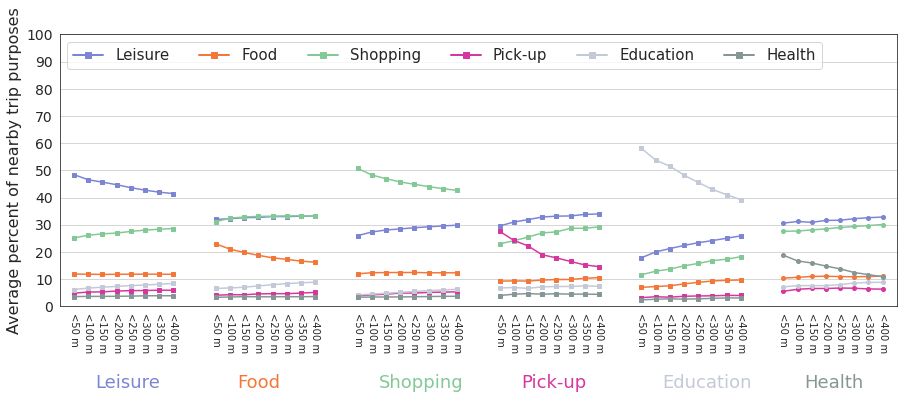

In [35]:
sns.set_style('white')
fig, ax = plt.subplots(1, figsize=(15,5))
# markers = ['$L$','$S$','$C$','$P$','$E$','$H$']
LONG_NAMES = ['Leisure','Food','Shopping','Pick-up','Education','Health']
COLOURBLIND_PALETTE = ["#7b85d4","#f37738","#83c995","#d7369e","#c4c9d8","#859795","#e9d043","#ad5b50", "#ffa07a", "k"]
# markers = ['o','v','*','s','P','D']
# for i in range(6):
#     ax.scatter(*create_x_y(), marker=markers[i], c=COLOURBLIND_PALETTE[i],alpha=.75, s=100)
for i in range(6):
    ax.plot(create_x_coords(start_val=0, number_vals=8),get_slice(all_av_np_df, i, 0),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=5, number_vals=8),get_slice(all_av_np_df, i, 1),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=10, number_vals=8),get_slice(all_av_np_df, i, 2),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=15, number_vals=8),get_slice(all_av_np_df, i, 3),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=20, number_vals=8),get_slice(all_av_np_df, i, 4),
           marker='s', markersize=4,c=COLOURBLIND_PALETTE[i])
    ax.plot(create_x_coords(start_val=25, number_vals=8),get_slice(all_av_np_df, i, 5),
           marker='o', markersize=4,c=COLOURBLIND_PALETTE[i])
    
legend_elements = [mlines.Line2D([0], [0], color=COLOURBLIND_PALETTE[i],marker='s', lw=2,) for i in range(len(COLOURBLIND_PALETTE))]

plt.xlim(-0.5,29)
plt.ylim(0,100)
plt.xticks(x_ticks, ['<50 m','<100 m','<150 m', '<200 m','<250 m','<300 m','<350 m','<400 m']*6,fontsize=10, rotation=-90);
plt.yticks(np.arange(0,101,10),size=14)
plt.ylabel("Average percent of nearby trip purposes", size=16)
to_add = 5
value = 0
for i, nm in enumerate(LONG_NAMES):
    plt.text(value+0.75,-30, nm, c=COLOURBLIND_PALETTE[i],size=18)
    value+=to_add
ax.grid(axis='y')
ax.legend(legend_elements, LONG_NAMES,fontsize=15, loc='upper left', ncol=len(LONG_NAMES), fancybox=True)
# plt.savefig('../../other/images/average_nearby_trip_purposes.tif',bbox_inches='tight', dpi = 300)

# 3. Evaluation of POI distribution by trip purpose